In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'E:/Dropbox/codigos/image_explorer/')

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchtrainer.imagedataset import ImageDataset, ImageSegmentationDataset
import albumentations as aug
from albumentations.pytorch import ToTensorV2
from image_explorer import InteractiveExperimenter

### Tests for ImageDataset

All images read
3D P0@CTL-3-FC-A_new


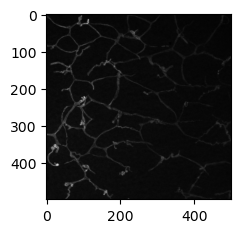

In [5]:
def test_dataset(img_dir):

    name_to_label_map = lambda x: x.split('.')[0]
    def file_filter1(x):
        return '3D P0@CTL-3-FC-A_new.tiff' in x
    file_filter2 = ['3D P0@CTL-3-FC-A_new.tiff']
    def img_opener(path):
        return Image.open(path)
    def transform(image):
        image = np.asarray(image)
        transform_ = aug.RandomCrop(500, 500)
        return transform_(image=image)['image']
    cache_size1 = 1e10
    
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=file_filter1, img_opener=None, cache_size=0)
    ds[0]
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=file_filter2, img_opener=None, cache_size=0)
    ds[0]
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=None, img_opener=img_opener, cache_size=0)
    ds[0]
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=None, img_opener=None, cache_size=cache_size1)
    ds[0]
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=file_filter1, img_opener=img_opener, cache_size=cache_size1)
    ds[0]
    ds = ImageDataset(img_dir, name_to_label_map, filename_filter=None, img_opener=None, transform=transform, cache_size=0)
    ds.check_dataset()
    ds_train, ds_val = ds.split_train_val(valid_set=0.2, seed=42)
    assert len(ds_train)+len(ds_val)==len(ds)

    return ds[0]

img_dir = Path('H:/datasets/segmentation/vessel/maximum_projection/images')
img, label = test_dataset(img_dir)
print(label)
plt.figure()
plt.imshow(img, 'gray')

### Tests for ImageSegmentationDataset

All images read


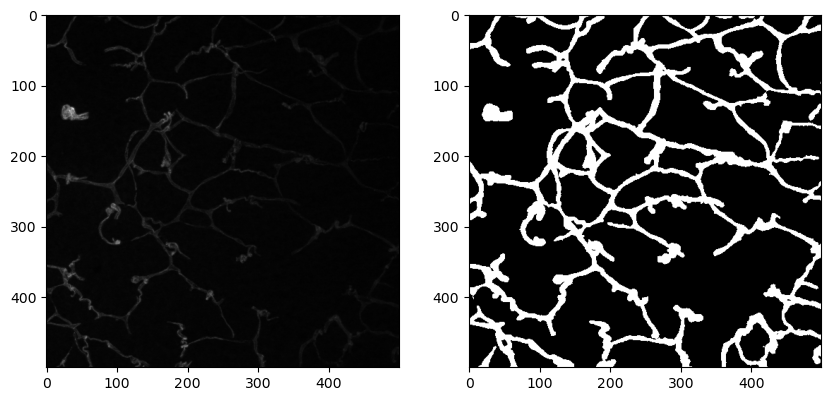

In [7]:
def test_dataset(img_dir, label_dir):

    name_to_label_map = lambda x: x.replace('tiff', 'png')
    def file_filter1(x):
        return '3D P0@CTL-3-FC-A_new.tiff' in x
    file_filter2 = ['3D P0@CTL-3-FC-A_new.tiff']
    def img_opener(path):
        return Image.open(path)
    def label_opener(path):
        return Image.open(path)
    def transform(image, label):
        image = np.asarray(image)
        label = np.asarray(label)
        transform_ = aug.RandomCrop(500, 500)
        res = transform_(image=image, mask=label)
        image, label = res['image'], res['mask']
        return image, label
    cache_size1 = 1e10
    
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=None, img_opener=None,
                                  label_opener=None, transform=None, cache_size=0)
    ds[0]
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=file_filter1, img_opener=img_opener,
                                  label_opener=label_opener, transform=None, cache_size=0)
    ds[0]
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=file_filter2, img_opener=img_opener,
                                  label_opener=label_opener, transform=None, cache_size=0)
    ds[0]
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=None, img_opener=None,
                                  label_opener=None, transform=transform, cache_size=0)
    ds[0]
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=None, img_opener=None,
                                  label_opener=None, transform=None, cache_size=cache_size1)
    ds[0]
    ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map, filename_filter=None, img_opener=None,
                                  label_opener=None, transform=transform, cache_size=0)
    ds.check_dataset()
    ds_train, ds_val = ds.split_train_val(valid_set=0.2, seed=42)
    assert len(ds_train)+len(ds_val)==len(ds)

    return ds[0]

img_dir = Path('H:/datasets/segmentation/vessel/maximum_projection/images')
label_dir = Path('H:/datasets/segmentation/vessel/maximum_projection/labels')
img, label = test_dataset(img_dir, label_dir)
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.imshow(img, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(label, 'gray')

### Image augmentations

In [7]:
img_dir = Path('H:/datasets/segmentation/vessel/maximum_projection/images')
ds = ImageDataset(img_dir, lambda x:x)
img, label = ds[0]
img = np.array(img)

In [8]:
def generate_multiplicative(mult_val_limit):
    """Generate custom function for Albumentations. The augmentation multiply
    the image by a constant value drawn uniformly in the range defined by `mult_val_limit`."""
    def custom(img, **kwargs):
        mult_val = np.random.rand()*(mult_val_limit[1]-mult_val_limit[0]) + mult_val_limit[0]
        return (img*mult_val).astype(np.uint8)
    return custom

crop_height = 500
crop_width = 500

def transform(image, mask=None):

    transform_comp = aug.Compose([
        aug.RandomCrop(crop_height, crop_width),
        aug.OneOf([
            aug.GaussianBlur(blur_limit=(3, 11)),
            aug.Sharpen(alpha=(0.2, 0.5), lightness=(0., 1.)),
            aug.UnsharpMask(blur_limit=(3, 15), alpha=(0.4, 1.), threshold=0)  # slow, 0.038s/img
        ], p=1.),
        aug.OneOf([
            aug.RandomGamma(gamma_limit=(80, 150)),
            aug.RandomBrightnessContrast(brightness_limit=(-0.15, 0.3), contrast_limit=(-0.2, 0.5)),
            aug.Lambda(name='multiply', image=generate_multiplicative((0.9,1.1)), p=0.1)
        ], p=1.),
        aug.GaussNoise(var_limit=(50, 200), p=1.),  # slow, 0.051s/img
        aug.Flip() ,
        aug.RandomRotate90(),
        aug.Transpose(),
        aug.ShiftScaleRotate(shift_limit_x=0.1, shift_limit_y=0.1, scale_limit=0.25, rotate_limit=45),
        aug.CLAHE(clip_limit=(1., 2.), tile_grid_size=(16, 16), p=0.1),
        #aug.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
        ToTensorV2(),
    ])

    return transform_comp(image=image, mask=mask)

In [ ]:
img = np.array(img)
plt.figure()
plt.imshow(img, 'gray')
plt.figure(figsize=[15, 15])
for i in range(25):
    img_transf = transform(image=img)['image'][0]
    plt.subplot(5, 5, i+1)
    plt.imshow(img_transf, 'gray')

In [ ]:
%matplotlib widget 
def plotter(img, blur_limit, alpha, lightness, blur_limit2, alpha2, threshold, gamma_limit,
            brightness_limit, contrast_limit, var_limit, clip_limit, tile_grid_size, shift_limit, 
            scale_limit, rotate_limit, add_val):
    def generate_additive(add_val_limit):
        def custom(img, **kwargs):
            add_val = np.random.randint(add_val_limit[0], add_val_limit[1])
            return img+add_val
        return custom

    transform = aug.Compose([
    aug.GaussianBlur(blur_limit=(blur_limit, blur_limit), p=1.),
    aug.Sharpen(alpha=(alpha, alpha), lightness=(lightness, lightness), p=1.),
    aug.UnsharpMask(blur_limit=(blur_limit2, blur_limit2),  
                    alpha=(alpha2, alpha2), threshold=threshold, p=1.),
    aug.RandomGamma(gamma_limit=(gamma_limit, gamma_limit), p=1.),
    aug.RandomBrightnessContrast(brightness_limit=(brightness_limit, brightness_limit), 
                                 contrast_limit=(contrast_limit, contrast_limit), p=1.), 
    aug.GaussNoise(var_limit=(var_limit, var_limit), p=1.),
    aug.CLAHE(clip_limit=(clip_limit, clip_limit), tile_grid_size=(tile_grid_size, tile_grid_size), p=1.),
    aug.ShiftScaleRotate(shift_limit=(shift_limit,shift_limit), scale_limit=(scale_limit,scale_limit), rotate_limit=(rotate_limit,rotate_limit), p=1.),
    aug.Lambda(image=generate_additive((add_val,add_val+1)), p=1.0)
    ])
    res = transform(image=img)['image']
    return res

params = {
    'blur_limit' : range(1, 12, 2),
    'alpha' : np.linspace(0.2, 0.5, 10),
    'lightness' : np.linspace(0, 1., 10),
    'blur_limit2' : range(1, 16, 2),
    'alpha2' : np.linspace(0.4, 1., 10),
    'threshold' : range(0, 1, 5),
    'gamma_limit' : np.linspace(80, 150, 101),
    'brightness_limit' : np.linspace(-0.15, 0.3, 11),
    'contrast_limit' : np.linspace(-0.2, 0.5, 101),
    'var_limit' : np.linspace(50, 200, 101),
    'clip_limit' : np.linspace(1., 2, 2),
    'tile_grid_size' : range(16, 17, 4),
    'shift_limit' : np.linspace(-0.1, 0.1, 11),
    'scale_limit' : np.linspace(-0.25, 0.25, 11),
    'rotate_limit' : np.linspace(-45, 45, 11),
    'add_val': range(-40, 41)
}

ie = InteractiveExperimenter(params, plotter, figsize=[5,5])
img = np.array(ds[0][0])[:400, :400]
ie.run(img)

In [6]:
import time

def generate_multiplicative(mult_val_limit):
    """Generate custom function for Albumentations. The augmentation multiply
    the image by a constant value drawn uniformly in the range defined by `mult_val_limit`."""
    def custom(img, **kwargs):
        mult_val = np.random.rand()*(mult_val_limit[1]-mult_val_limit[0]) + mult_val_limit[0]
        return (img*mult_val).astype(np.uint8)
    return custom

def get_transf(transf):
    def transform(image):
        image = np.asarray(image)
        return transf(image=image)['image']  
    return transform

transfs = [
    aug.RandomCrop(500, 500),
    aug.GaussianBlur(blur_limit=(3, 11), p=1.),
    aug.Sharpen(alpha=(0.2, 0.5), lightness=(0., 1.), p=1.),
    aug.UnsharpMask(blur_limit=(3, 15), alpha=(0.4, 1.), threshold=0, p=1.),
    aug.RandomGamma(gamma_limit=(80, 150), p=1.),
    aug.RandomBrightnessContrast(brightness_limit=(-0.15, 0.3), contrast_limit=(-0.2, 0.5), p=1.),
    aug.Lambda(name='multiply', image=generate_multiplicative((0.9,1.1)), p=1.),
    aug.GaussNoise(var_limit=(50, 200), p=1.),
    aug.Flip(p=1.),
    aug.RandomRotate90(p=1.),
    aug.Transpose(p=1.),
    aug.ShiftScaleRotate(shift_limit_x=0.1, shift_limit_y=0.1, scale_limit=0.25, rotate_limit=45, p=1.),
    aug.CLAHE(clip_limit=(1., 2.), tile_grid_size=(16, 16), p=1.),
    ToTensorV2()
]

times = []
for transf in transfs:
    transf_func = get_transf(transf)

    ds = ImageDataset(img_dir, lambda x:x, transform=transf_func)
    t0 = time.time()
    ds.check_dataset()
    t1 = time.time()
    tt = t1-t0
    times.append(tt)
    print(f'{transf}: {tt}')
print(times)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

KeyboardInterrupt: 

In [10]:
136/len(ds)


0.051495645588792126